In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load_data import load_gt_data
from statsmodels.tsa.seasonal import seasonal_decompose

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
SEED = 42

In [142]:
gt_data = load_gt_data()

gt_data['date'] = pd.to_datetime(gt_data['date'])
gt_data = gt_data.sort_values(by='date')

gt_data

,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,Agile_software_development_average,Subsidy_average,Sustainability_average,Open_innovation_average,Industrial_park_average,Semiconductor_average,Artificial_intelligence_average,International_Financial_Reporting_Standards_average,Employment_average,country
0,2004-01-01,0.0,0.0,0.0,90.0,27.0,43.0,0.0,88.0,35.0,...,0.0,7.6,46.0,0.0,0.0,71.0,12.0,91.0,64.0,Switzerland
1470,2004-01-01,39.0,85.0,31.0,98.0,34.0,65.0,9.0,93.0,54.0,...,38.0,35.0,40.0,0.0,34.0,98.0,6.0,18.0,100.0,United States
245,2004-01-01,69.0,53.0,38.0,84.0,20.0,68.0,0.0,99.0,58.0,...,13.0,22.0,27.0,0.0,100.0,99.0,6.0,34.0,61.0,Germany
735,2004-01-01,74.0,72.0,0.0,14.0,39.0,41.0,0.0,64.0,58.0,...,37.0,17.0,12.0,0.0,54.0,100.0,13.0,0.0,39.0,Japan
980,2004-01-01,22.0,97.0,0.0,89.2,31.0,27.0,0.0,62.0,53.0,...,20.0,14.0,65.0,0.0,0.0,59.0,5.0,0.0,84.0,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,2024-05-01,55.0,32.0,59.0,50.0,92.0,79.0,2.0,71.0,62.0,...,62.0,19.0,69.0,17.0,3.0,21.0,95.0,28.0,20.0,Germany
244,2024-05-01,62.0,20.0,77.0,74.0,91.0,64.2,2.0,84.0,72.0,...,66.0,71.0,82.0,10.0,21.4,28.0,93.0,24.8,78.0,Switzerland
1469,2024-05-01,83.0,28.0,29.0,93.0,89.0,89.0,3.0,77.0,44.0,...,73.2,38.4,100.0,5.0,2.0,37.0,98.0,17.0,93.0,Korea
1224,2024-05-01,41.0,24.6,49.0,74.6,91.0,51.0,1.0,57.0,60.0,...,70.0,20.0,75.0,4.0,60.0,18.0,88.0,45.0,59.0,Canada


In [143]:
gt_cols = [col for col in gt_data.columns if col not in ['date', 'country']]

gt_data_melted = gt_data.melt(id_vars=['date', 'country'], value_vars=gt_cols)

gt_data_melted

,date,country,variable,value
0,2004-01-01,Switzerland,Expense_average,0.0
1,2004-01-01,United States,Expense_average,39.0
2,2004-01-01,Germany,Expense_average,69.0
3,2004-01-01,Japan,Expense_average,74.0
4,2004-01-01,Canada,Expense_average,22.0
...,...,...,...,...
161205,2024-05-01,Germany,Employment_average,20.0
161206,2024-05-01,Switzerland,Employment_average,78.0
161207,2024-05-01,Korea,Employment_average,93.0
161208,2024-05-01,Canada,Employment_average,59.0


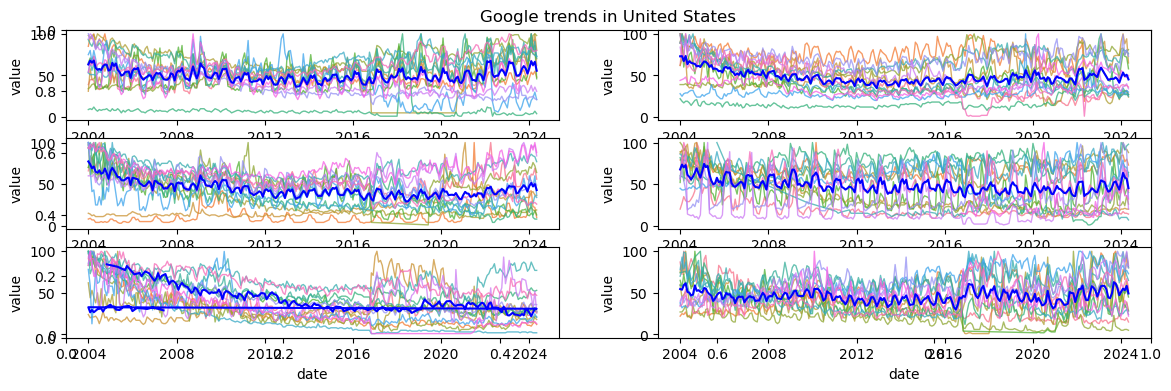

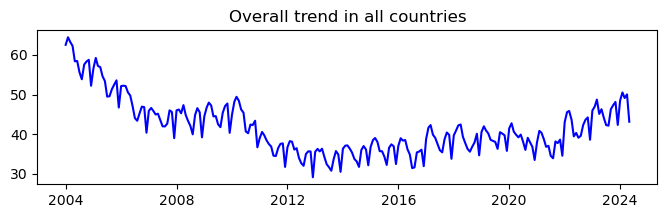

In [144]:
def plot_overall_trend(data, country, col=None, col_label=None, new_figs=True):
    
    cols = [col for col in data.columns if col not in ['date', 'country']]

    data_melted = data.melt(id_vars=['date', 'country'], value_vars=cols)

    country_mask = data_melted['country'] == country
    zero_mask = data_melted['value'] != 0

    if col is not None:
        if new_figs:
            plt.figure(figsize=(8,4))

        mask = country_mask & zero_mask & (data_melted['variable'] == cols[-1])

        plt.title(f'Google trends in {country} for {col}')

        sns.lineplot(data_melted[mask], x='date', y='value', linewidth=1, label=col_label)
    else:
        if new_figs:
            plt.figure(figsize=(14,4))

        masks = {}
        for i in range(6):
            masks[i] = country_mask & zero_mask & data_melted['variable'].isin(cols[(i*15):((i+1)*15)])

        plt.title(f'Google trends in {country}')
        for i in range(6):
            plt.subplot(int(f"32{i+1}"))
            sns.lineplot(data_melted[masks[i]], x='date', y='value', hue='variable', legend=None, linewidth=1, alpha=0.75)
            plt.plot(data_melted[masks[i]]['date'].unique(), data_melted[masks[i]].groupby('date')['value'].agg("mean"), color='b')

        plt.show()

        plt.figure(figsize=(8, 2))
        plt.title(f"Overall trend in all countries")
        plt.plot(data_melted[zero_mask]['date'].unique(), data_melted[zero_mask].groupby('date')['value'].agg("mean"), color='b')
        plt.show()

plot_overall_trend(gt_data, "United States")


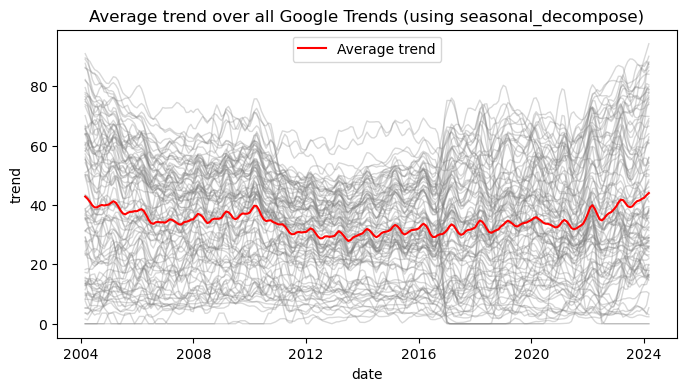

In [145]:
def get_average_trend(data, plot=False):
    data = data.copy()

    gt_cols = [col for col in data.columns if col not in ['date', 'country']]

    data = data.drop('country', axis=1).groupby('date').mean()
    
    trends, seasonals, residuals = {}, {}, {}
    for col in gt_cols:
        decompose_result = seasonal_decompose(data[col], model="additive", period=4)

        trends[col] = decompose_result.trend
        seasonals[col] = decompose_result.seasonal
        residuals[col] = decompose_result.resid

    mean_trend = np.mean([trends[col] for col in trends], axis=0)
    if plot:
        plt.figure(figsize=(8, 4))

        for col in trends:
            sns.lineplot(x=data.index, y=trends[col], color='gray', alpha=0.3, linewidth=1)

        sns.lineplot(x=data.index, y=mean_trend, color='red', label="Average trend")
        plt.title('Average trend over all Google Trends (using seasonal_decompose)')

    return mean_trend



mean_trend = get_average_trend(gt_data, plot=True)

In [148]:

from sklearn.decomposition import PCA
from statsmodels.tsa.filters.hp_filter import hpfilter

def remove_common_component(data):
	data = data.copy()

	category_means = data.drop('country', axis=1).groupby('date').mean()
	means_log = category_means.apply(np.log1p)


	hp_output = means_log.apply(lambda x: hpfilter(x, lamb=1600)[1]) # remove seasonality

	mean, std = hp_output.mean(), hp_output.std()

	hp_output = (hp_output - mean) / std

	pca = PCA(n_components=1)
	pca.fit(hp_output)

	common_component = pca.transform(hp_output) * mean.std() + mean.mean()

	# for each value, subtract the common component of the corresponding date
	for date_index, date in enumerate(data['date'].sort_values().unique()):
		date_mask = data['date'] == date
		data.loc[date_mask, gt_cols] -= common_component[date_index].item()

	data[gt_cols] = np.expm1(data[gt_cols])

	return data

detrended_gt_data = remove_common_component(gt_data)

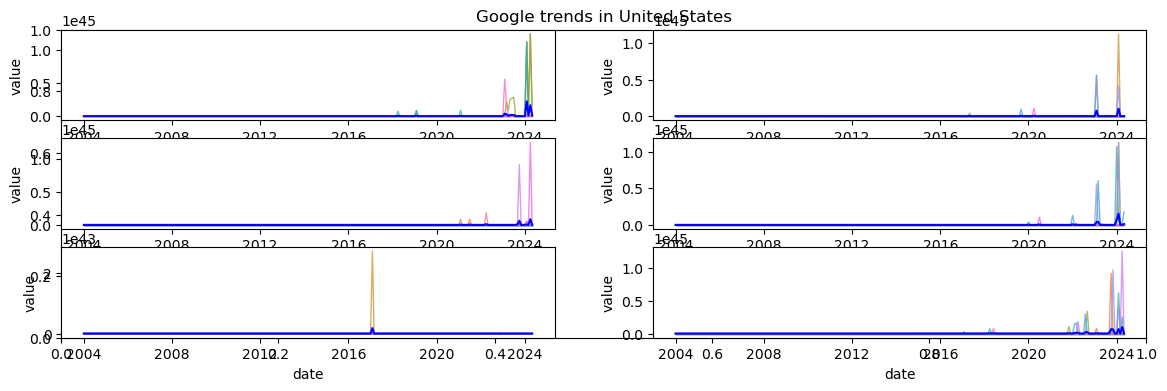

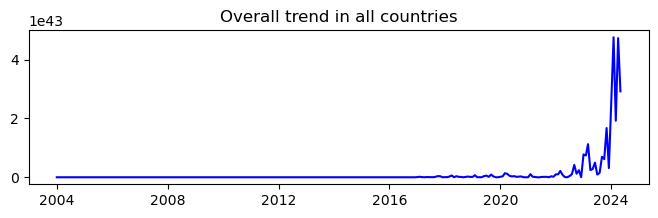

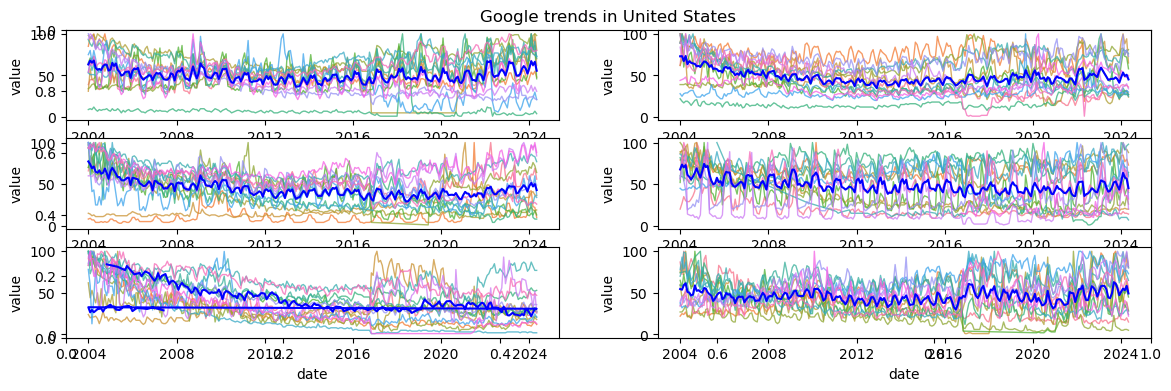

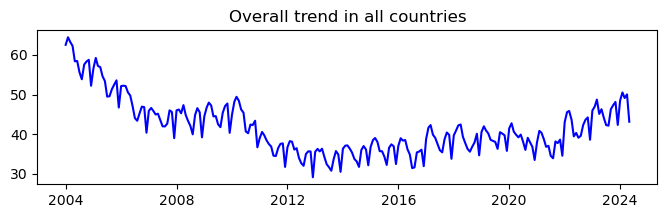

In [147]:
plot_overall_trend(detrended_gt_data, "United States")
plot_overall_trend(gt_data, "United States")